### Домашнее задание основано на соревновании: 
https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
#### Цель: обучить текстовый классификатор на простых фичах с помощью Spark ML
1) **HashingTF и IDF - 70 баллов**
2) Word2Vec - 30 баллов - в ноутбуке **hw5_pyspark_Word2Vec**<br>

ДЗ предлагается сделать в ноутбуке и в формате ipynb загрузить в репозиторий на Github и прислать ссылку на него в интерфейсе сдачи

In [1]:
#!pip install findspark
#!pip install pandas
#!pip install matplotlib

## Необходимые библиотеки

In [2]:
import findspark
findspark.init("/opt/spark")
import random
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

In [3]:
spark = SparkSession.builder.appName('tf_idf').getOrCreate()

22/12/05 16:23:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## Загрузка данных

Загружаем только тренировочные данные, на них будем учить и валидировать. Для тестовых данных меток на kaggle нет, поэтому их не рассматриваем.

In [4]:
# Так не вышло считать - криво разбивалось из-за запятых и \n в текстах
# Использовала предобработанный датасет ниже
#df = spark.read.option("lineSep", "\n").option("multiLine","true").csv("data/train.csv", header = True, inferSchema = True)
#df.printSchema()

In [5]:
df = spark.read.csv("data/train_prep.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



Посмотрим на данные

In [6]:
print((df.count(), len(df.columns)))

(159571, 8)


In [7]:
df.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|ExplanationWhy th...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man I'm reall...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|"""MoreI can't ma...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You sir are my he...|    0|           0|      0|     0|     0|            0|
|00025465d4725e87|"""Congratulation...|    0|           0|      0|     0|     0|            0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|           1|      1|     0|     1|            0|
|00031b1e95af7921|Your vandalism to...|    0|     

## Подготовка данных

Посмотрим, где есть пропуски.

In [8]:
print(f"Пропуски в колонке id: {df.filter('id IS NULL').count()} ({100 * df.filter('id IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке comment_text: {df.filter('comment_text IS NULL').count()} ({100* df.filter('comment_text IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке toxic: {df.filter('toxic IS NULL').count()} ({100 * df.filter('toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке severe_toxic: {df.filter('severe_toxic IS NULL').count()} ({100 * df.filter('severe_toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке obscene: {df.filter('obscene IS NULL').count()} ({100 * df.filter('obscene IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке threat: {df.filter('threat IS NULL').count()} ({100 * df.filter('threat IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке insult: {df.filter('insult IS NULL').count()} ({100 * df.filter('insult IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке identity_hate: {df.filter('identity_hate IS NULL').count()} ({100 * df.filter('identity_hate IS NULL').count() / df.count():.2f})%")

Пропуски в колонке id: 0 (0.00)%
Пропуски в колонке comment_text: 0 (0.00)%
Пропуски в колонке toxic: 8 (0.01)%
Пропуски в колонке severe_toxic: 8 (0.01)%
Пропуски в колонке obscene: 8 (0.01)%
Пропуски в колонке threat: 8 (0.01)%
Пропуски в колонке insult: 8 (0.01)%
Пропуски в колонке identity_hate: 8 (0.01)%


Удалим строки, где есть пропуски

In [9]:
df = df.dropna()
print(df.count())

159563


In [10]:
print(f"Пропуски в колонке id: {df.filter('id IS NULL').count()} ({100 * df.filter('id IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке comment_text: {df.filter('comment_text IS NULL').count()} ({100* df.filter('comment_text IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке toxic: {df.filter('toxic IS NULL').count()} ({100 * df.filter('toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке severe_toxic: {df.filter('severe_toxic IS NULL').count()} ({100 * df.filter('severe_toxic IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке obscene: {df.filter('obscene IS NULL').count()} ({100 * df.filter('obscene IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке threat: {df.filter('threat IS NULL').count()} ({100 * df.filter('threat IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке insult: {df.filter('insult IS NULL').count()} ({100 * df.filter('insult IS NULL').count() / df.count():.2f})%")
print(f"Пропуски в колонке identity_hate: {df.filter('identity_hate IS NULL').count()} ({100 * df.filter('identity_hate IS NULL').count() / df.count():.2f})%")

Пропуски в колонке id: 0 (0.00)%


Пропуски в колонке comment_text: 0 (0.00)%
Пропуски в колонке toxic: 0 (0.00)%
Пропуски в колонке severe_toxic: 0 (0.00)%


Пропуски в колонке obscene: 0 (0.00)%


Пропуски в колонке threat: 0 (0.00)%


Пропуски в колонке insult: 0 (0.00)%


Пропуски в колонке identity_hate: 0 (0.00)%


## Предварительная обработка данных

Удалим знаки препинания и цифры

In [11]:
df_prep = df.withColumn('comment_text', regexp_replace(df.comment_text, '[_()":\';,.!?\\-]', ''))
df_prep = df_prep.withColumn('comment_text', regexp_replace(df_prep.comment_text, '[0-9]', ''))

In [12]:
df_prep.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|ExplanationWhy th...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|Daww He matches t...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man Im really...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|MoreI cant make a...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You sir are my he...|    0|           0|      0|     0|     0|            0|
|00025465d4725e87|Congratulations f...|    0|           0|      0|     0|     0|            0|
|0002bcb3da6cb337|COCKSUCKER BEFORE...|    1|           1|      1|     0|     1|            0|
|00031b1e95af7921|Your vandalism to...|    0|     

Обработаем лишние пробелы

In [13]:
df_prep = df_prep.withColumn('comment_text', regexp_replace(df_prep.comment_text, ' +', ' '))

In [14]:
print(f"Пропуски в колонке comment_text: {df_prep.filter('comment_text IS NULL').count()}")

Пропуски в колонке comment_text: 0


Разобьем тексты на токены

In [15]:
df_prep = Tokenizer(inputCol='comment_text', outputCol='tokens').transform(df_prep)

Удалим стоп-слова

In [16]:
df_prep = df_prep.select('id', 'tokens','toxic','severe_toxic','obscene','threat','insult','identity_hate')
df_prep = StopWordsRemover(inputCol='tokens', outputCol='terms').transform(df_prep)

In [17]:
print(f"Пропуски в колонке terms: {df_prep.filter('terms IS NULL').count()}")

Пропуски в колонке terms: 0


In [18]:
df_prep.show(10)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|              id|              tokens|toxic|severe_toxic|obscene|threat|insult|identity_hate|               terms|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|0000997932d777bf|[explanationwhy, ...|    0|           0|      0|     0|     0|            0|[explanationwhy, ...|
|000103f0d9cfb60f|[daww, he, matche...|    0|           0|      0|     0|     0|            0|[daww, matches, b...|
|000113f07ec002fd|[hey, man, im, re...|    0|           0|      0|     0|     0|            0|[hey, man, im, re...|
|0001b41b1c6bb37e|[morei, cant, mak...|    0|           0|      0|     0|     0|            0|[morei, cant, mak...|
|0001d958c54c6e35|[you, sir, are, m...|    0|           0|      0|     0|     0|            0|[sir, hero, chanc...|
|00025465d4725e87|[congratulations,...|    0|           0|      0|     0

## TF-IDF

numFeatures=1024

In [19]:
#Hashing trick
df_prep_1024 = HashingTF(inputCol='terms', outputCol='hash', numFeatures=1024).transform(df_prep)

In [20]:
df_tf_idf_1024 = IDF(inputCol='hash', outputCol='features').fit(df_prep_1024).transform(df_prep_1024)

In [21]:
df_tf_idf_1024.select('terms', 'features').show(5)

+--------------------+--------------------+
|               terms|            features|
+--------------------+--------------------+
|[explanationwhy, ...|(1024,[19,96,147,...|
|[daww, matches, b...|(1024,[3,106,147,...|
|[hey, man, im, re...|(1024,[75,85,107,...|
|[morei, cant, mak...|(1024,[56,64,70,8...|
|[sir, hero, chanc...|(1024,[105,145,38...|
+--------------------+--------------------+
only showing top 5 rows



numFeatures=256

In [22]:
#Hashing trick
df_prep_256 = HashingTF(inputCol='terms', outputCol='hash', numFeatures=256).transform(df_prep)

In [23]:
df_tf_idf_256 = IDF(inputCol='hash', outputCol='features').fit(df_prep_256).transform(df_prep_256)

In [24]:
df_tf_idf_256.select('terms', 'features').show(5)

+--------------------+--------------------+
|               terms|            features|
+--------------------+--------------------+
|[explanationwhy, ...|(256,[17,19,32,39...|
|[daww, matches, b...|(256,[3,39,102,10...|
|[hey, man, im, re...|(256,[15,39,60,72...|
|[morei, cant, mak...|(256,[7,20,26,27,...|
|[sir, hero, chanc...|(256,[91,105,133,...|
+--------------------+--------------------+
only showing top 5 rows



## Классификаторы

Разделим данные на train и test

In [25]:
df_prep_1024 = df_tf_idf_1024.select('features','toxic','severe_toxic','obscene','threat','insult','identity_hate')
df_prep_256 = df_tf_idf_256.select('features','toxic','severe_toxic','obscene','threat','insult','identity_hate')
train_1024, test_1024 = df_prep_1024.randomSplit([0.8, 0.2], seed=0)
train_256, test_256 = df_prep_256.randomSplit([0.8, 0.2], seed=0)
train_1024 = train_1024.dropDuplicates()
test_1024 = test_1024.dropDuplicates()
train_256 = train_256.dropDuplicates()
test_256 = test_256.dropDuplicates()
print(train_1024.count(), test_1024.count(), train_256.count(), test_256.count())

126921 31693 126711 31666


In [26]:
train_1024.show(3)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|(1024,[0,32,99,13...|    0|           0|      0|     0|     0|            0|
|(1024,[0,48,78,28...|    1|           0|      0|     0|     0|            0|
|(1024,[0,56,168,1...|    0|           0|      0|     0|     0|            0|
+--------------------+-----+------------+-------+------+------+-------------+
only showing top 3 rows



In [27]:
test_1024.show(3)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|(1024,[2,39,97,14...|    0|           0|      0|     0|     0|            0|
|(1024,[5,16,181,1...|    0|           0|      0|     0|     0|            0|
|(1024,[5,36,319,4...|    1|           0|      1|     0|     1|            1|
+--------------------+-----+------------+-------+------+------+-------------+
only showing top 3 rows



In [28]:
train_256.show(3)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|(256,[0,1,2,4,5,6...|    0|           0|      0|     0|     0|            0|
|(256,[0,1,7,8,9,1...|    0|           0|      0|     0|     0|            0|
|(256,[0,1,10,14,2...|    0|           0|      0|     0|     0|            0|
+--------------------+-----+------------+-------+------+------+-------------+
only showing top 3 rows



In [29]:
test_256.show(3)

+--------------------+-----+------------+-------+------+------+-------------+
|            features|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+--------------------+-----+------------+-------+------+------+-------------+
|(256,[0,2,9,24,36...|    0|           0|      0|     0|     0|            0|
|(256,[0,4,7,12,19...|    0|           0|      0|     0|     0|            0|
|(256,[0,4,11,26,3...|    0|           0|      0|     0|     0|            0|
+--------------------+-----+------------+-------+------+------+-------------+
only showing top 3 rows



Данные у нас для мультилейбл-классификации, поэтому будем тренировать несколько классификаторов - по бинарному на каждый лейбл.<br>
Всего будет 12 классификаторов - по 6 на каждый датасет.

### 1. label: toxic

22/12/05 16:26:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/05 16:26:30 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/12/05 16:26:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/05 16:26:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


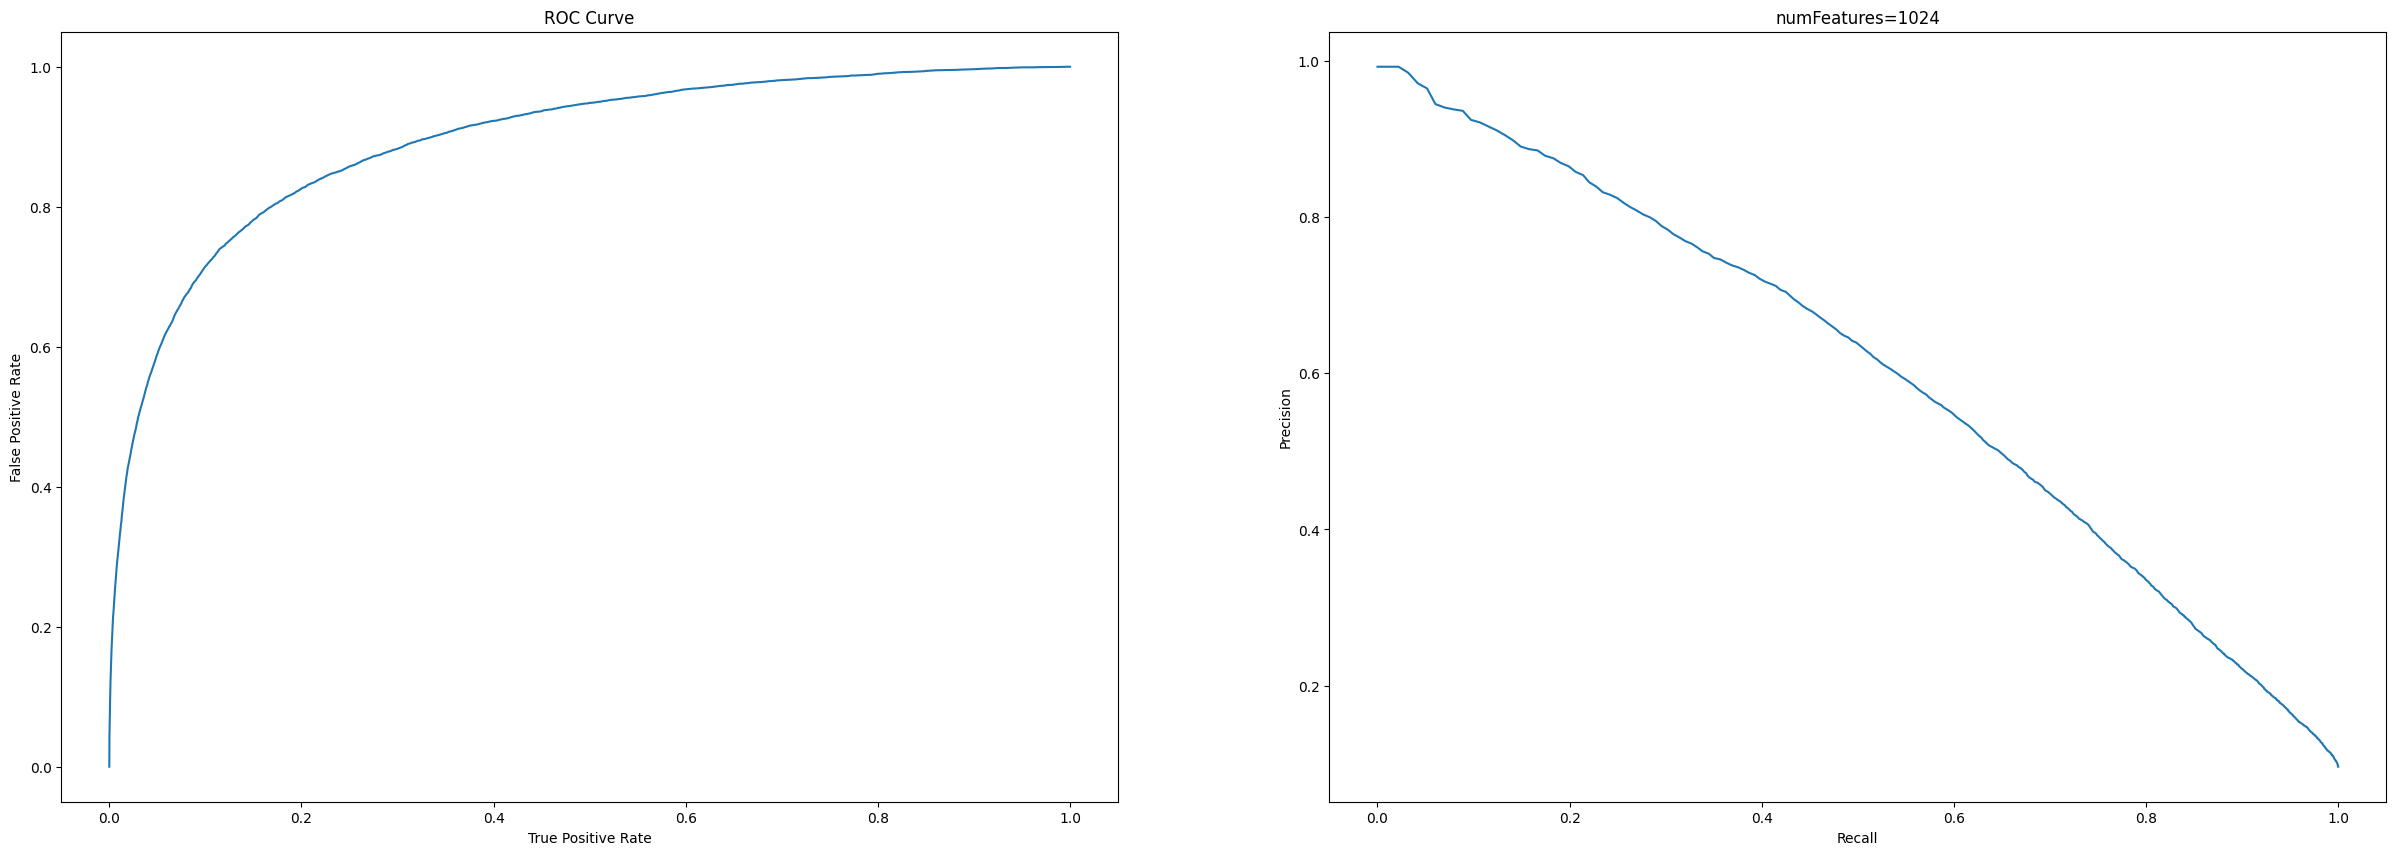

Train areaUnderROC: 0.8930635991991351
Test confusion matrix: toxic


+-----+----------+-----+
|toxic|prediction|count|
+-----+----------+-----+
|    1|       0.0| 2049|
|    0|       0.0|28321|
|    1|       1.0| 1000|
|    0|       1.0|  323|
+-----+----------+-----+



In [30]:
label = 'toxic'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

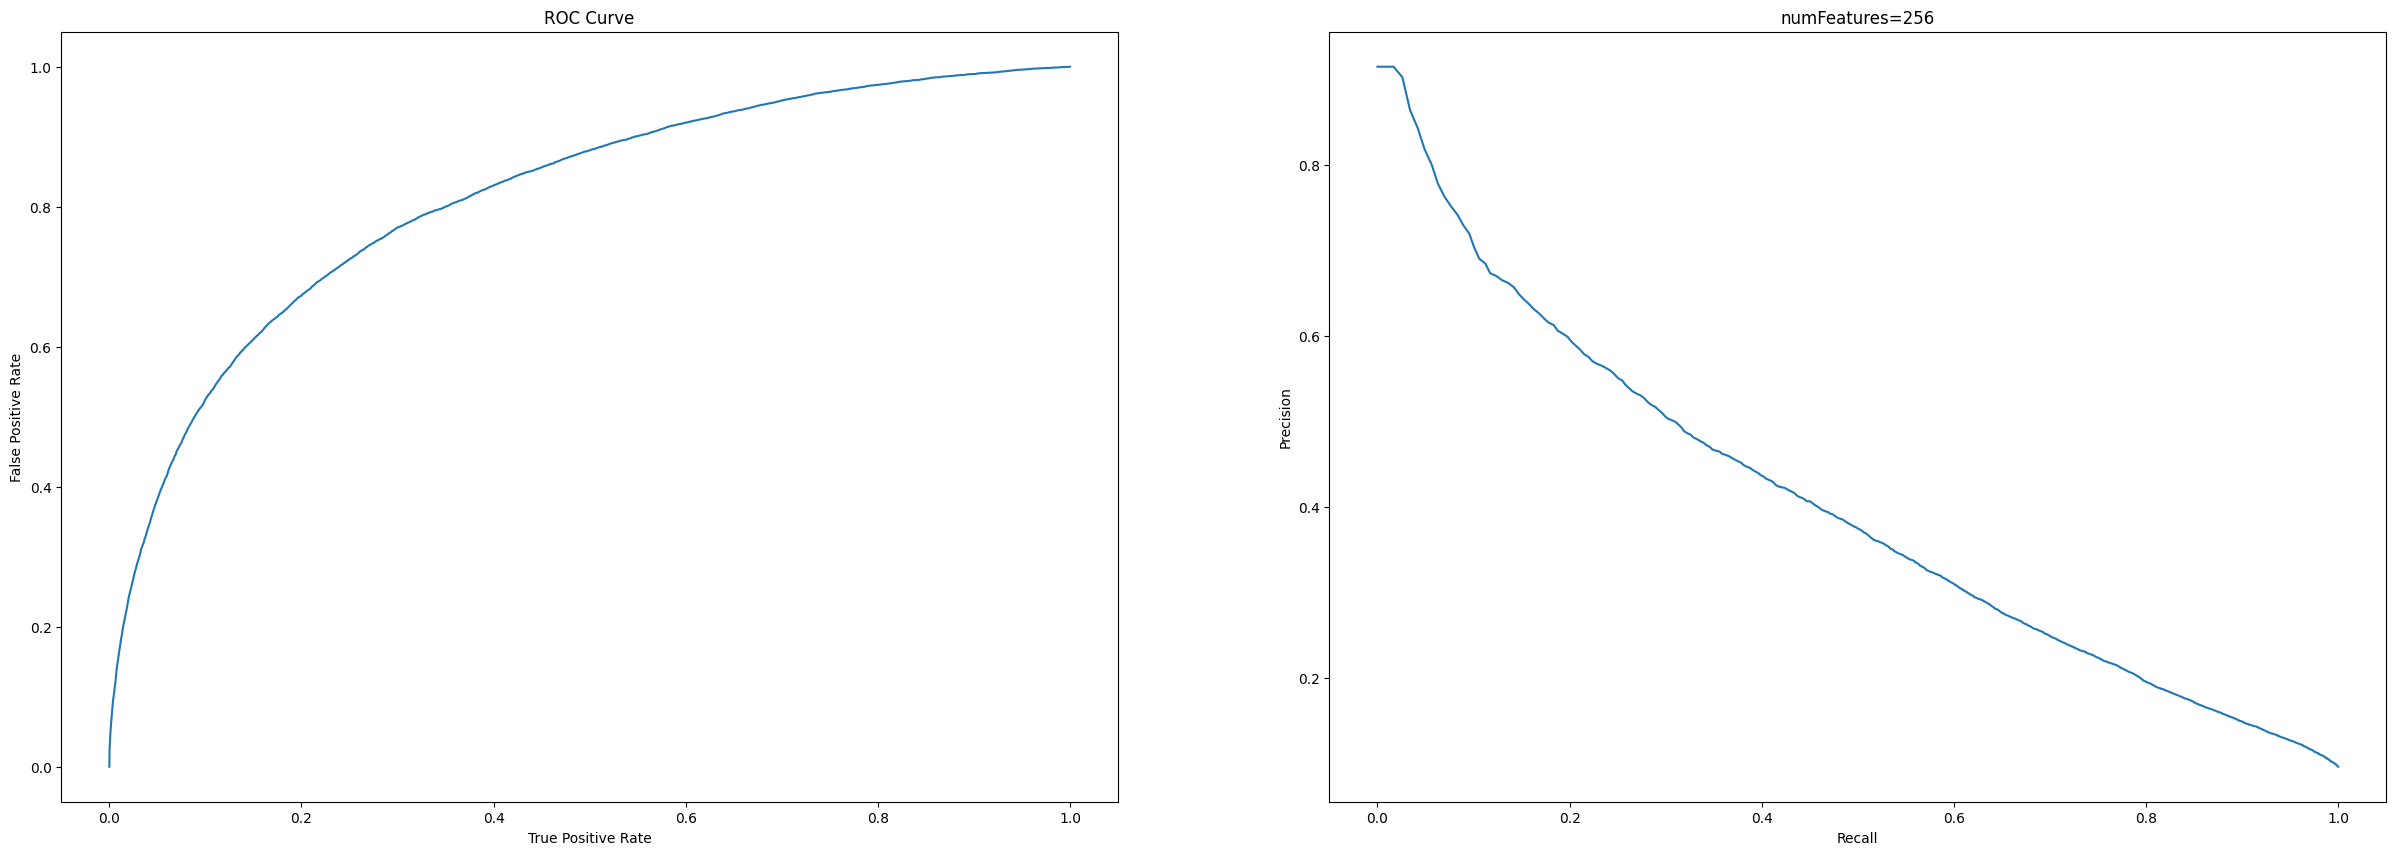

Train areaUnderROC: 0.8121859460112646
Test confusion matrix: toxic


+-----+----------+-----+
|toxic|prediction|count|
+-----+----------+-----+
|    1|       0.0| 2758|
|    0|       0.0|28430|
|    1|       1.0|  305|
|    0|       1.0|  173|
+-----+----------+-----+



In [31]:
label = 'toxic'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

### 2. label: severe_toxic

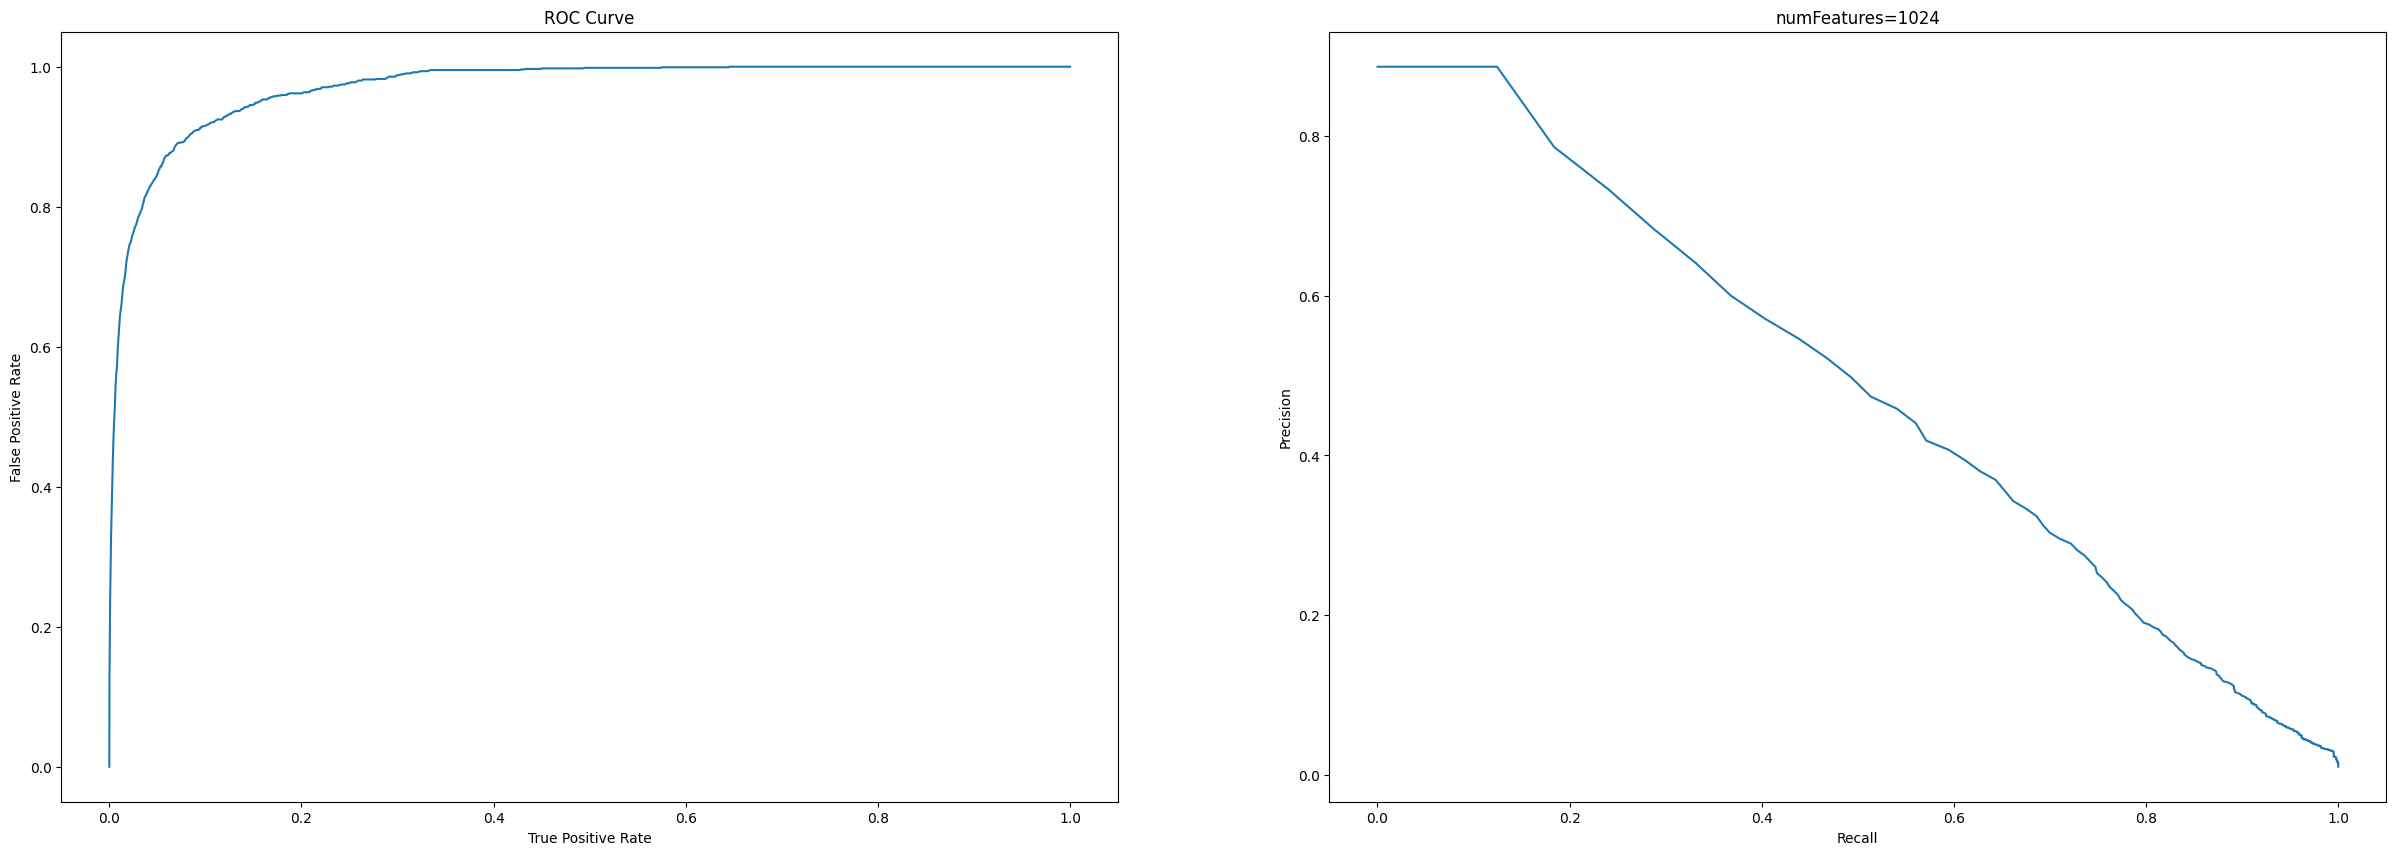

Train areaUnderROC: 0.9708756292609839
Test confusion matrix: severe_toxic


+------------+----------+-----+
|severe_toxic|prediction|count|
+------------+----------+-----+
|           1|       0.0|  274|
|           0|       0.0|31284|
|           1|       1.0|   56|
|           0|       1.0|   79|
+------------+----------+-----+



In [32]:
label = 'severe_toxic'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

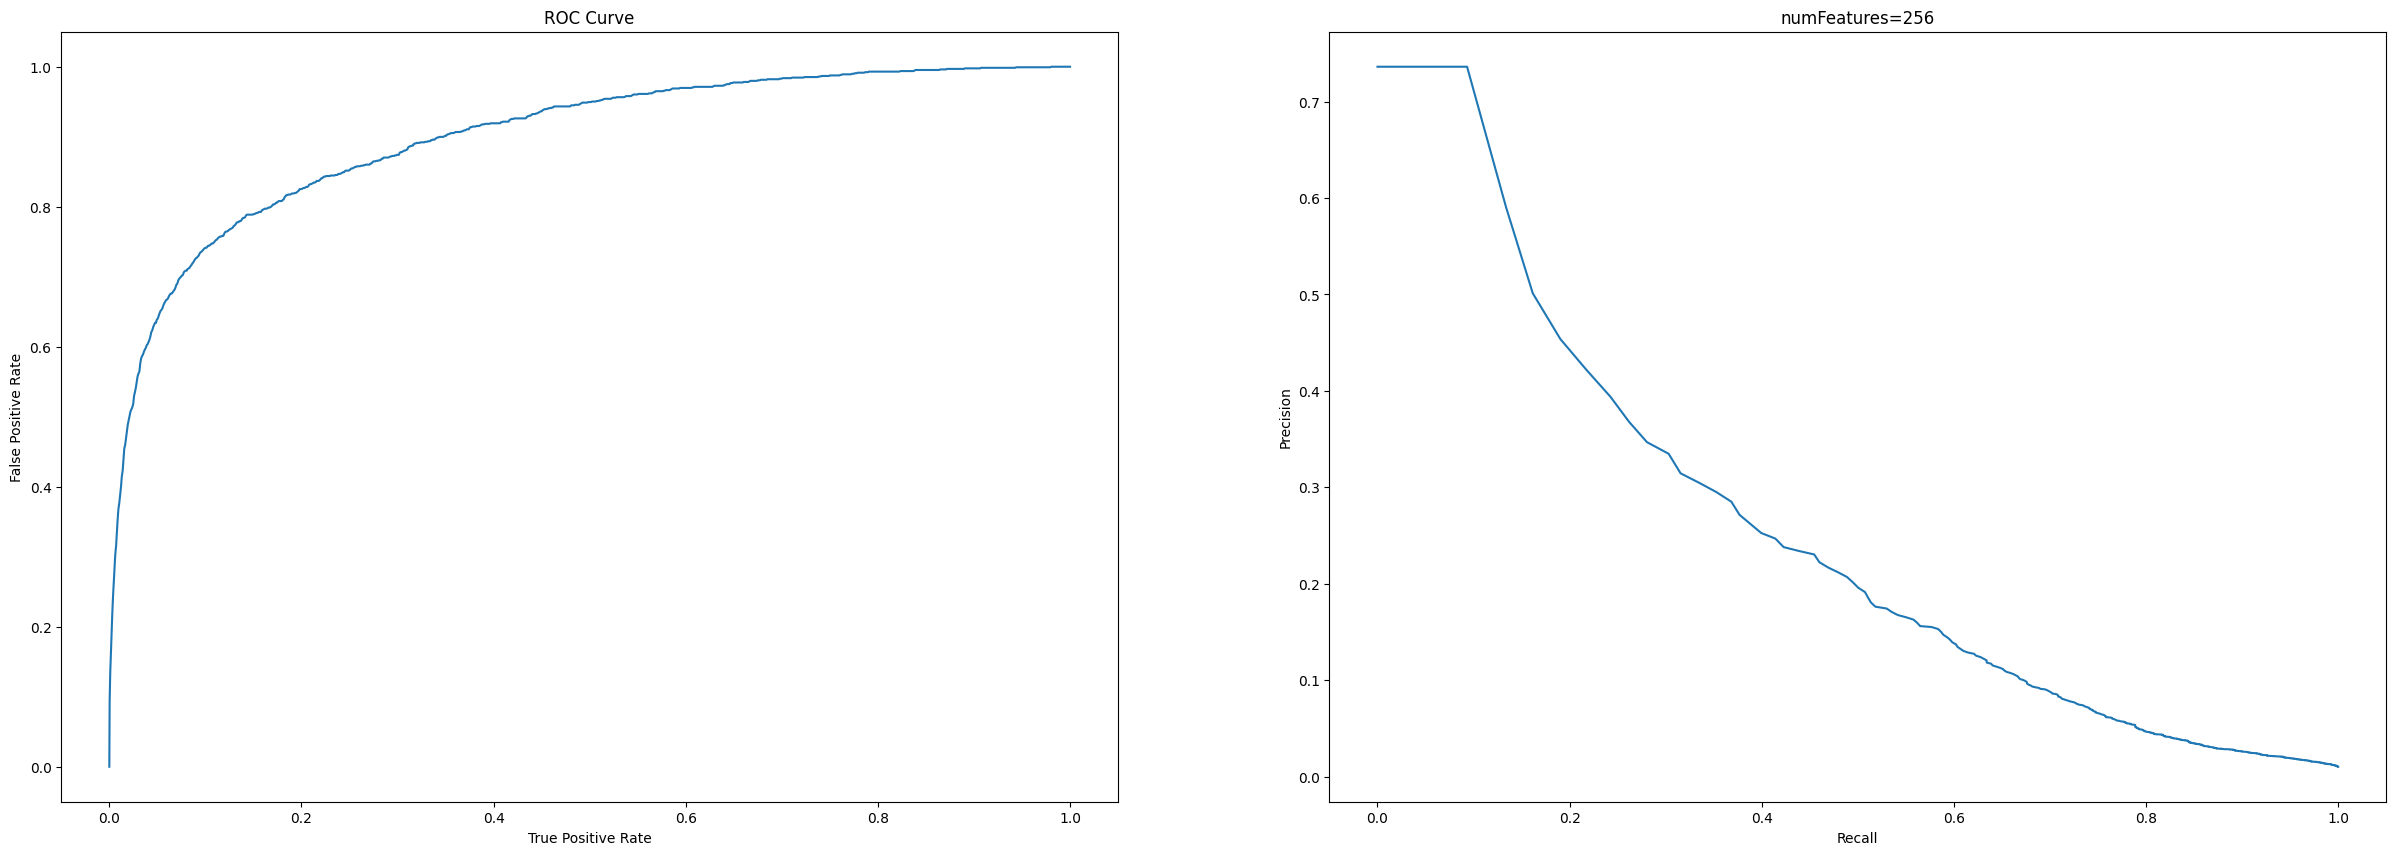

Train areaUnderROC: 0.8984702567988065
Test confusion matrix: severe_toxic


+------------+----------+-----+
|severe_toxic|prediction|count|
+------------+----------+-----+
|           1|       0.0|  289|
|           0|       0.0|31327|
|           1|       1.0|   17|
|           0|       1.0|   33|
+------------+----------+-----+



In [33]:
label = 'severe_toxic'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

### 3. label: obscene

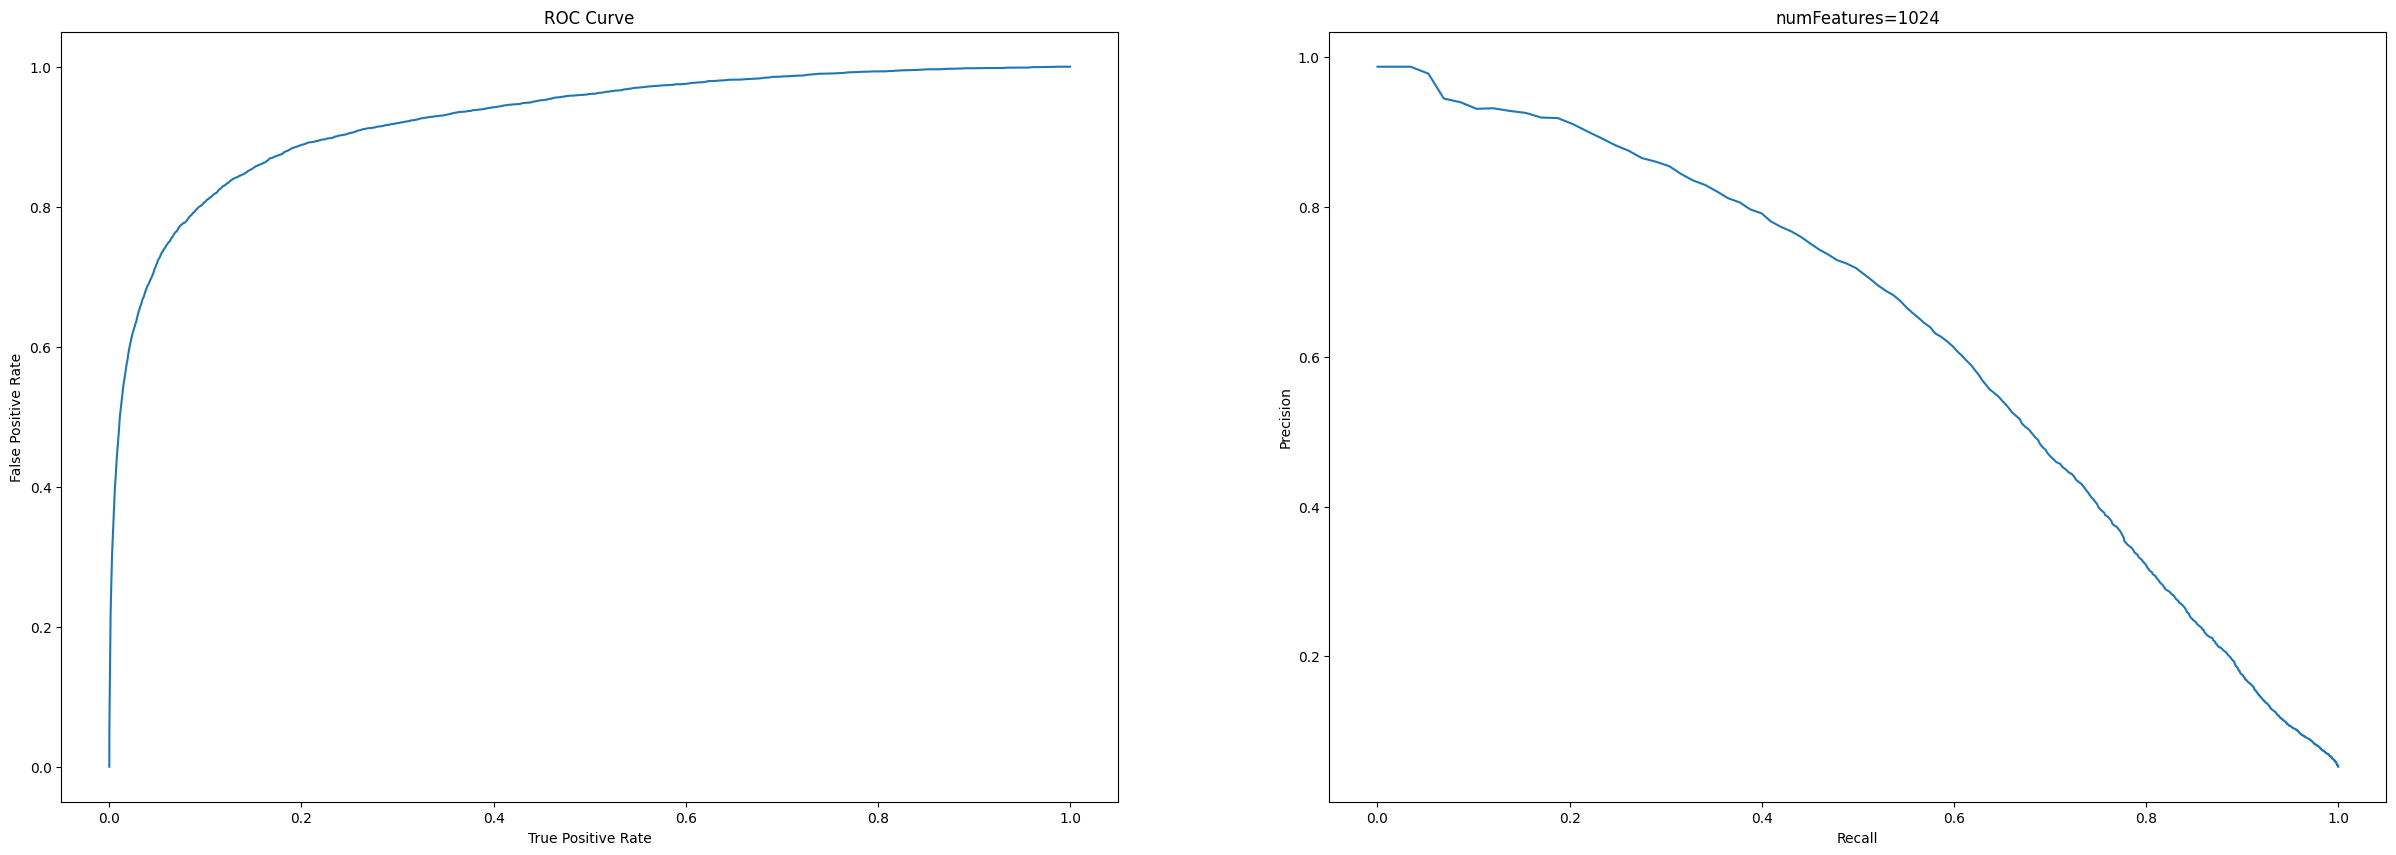

Train areaUnderROC: 0.9250521834667412
Test confusion matrix: obscene


+-------+----------+-----+
|obscene|prediction|count|
+-------+----------+-----+
|      1|       0.0| 1080|
|      0|       0.0|29756|
|      1|       1.0|  653|
|      0|       1.0|  204|
+-------+----------+-----+



In [34]:
label = 'obscene'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

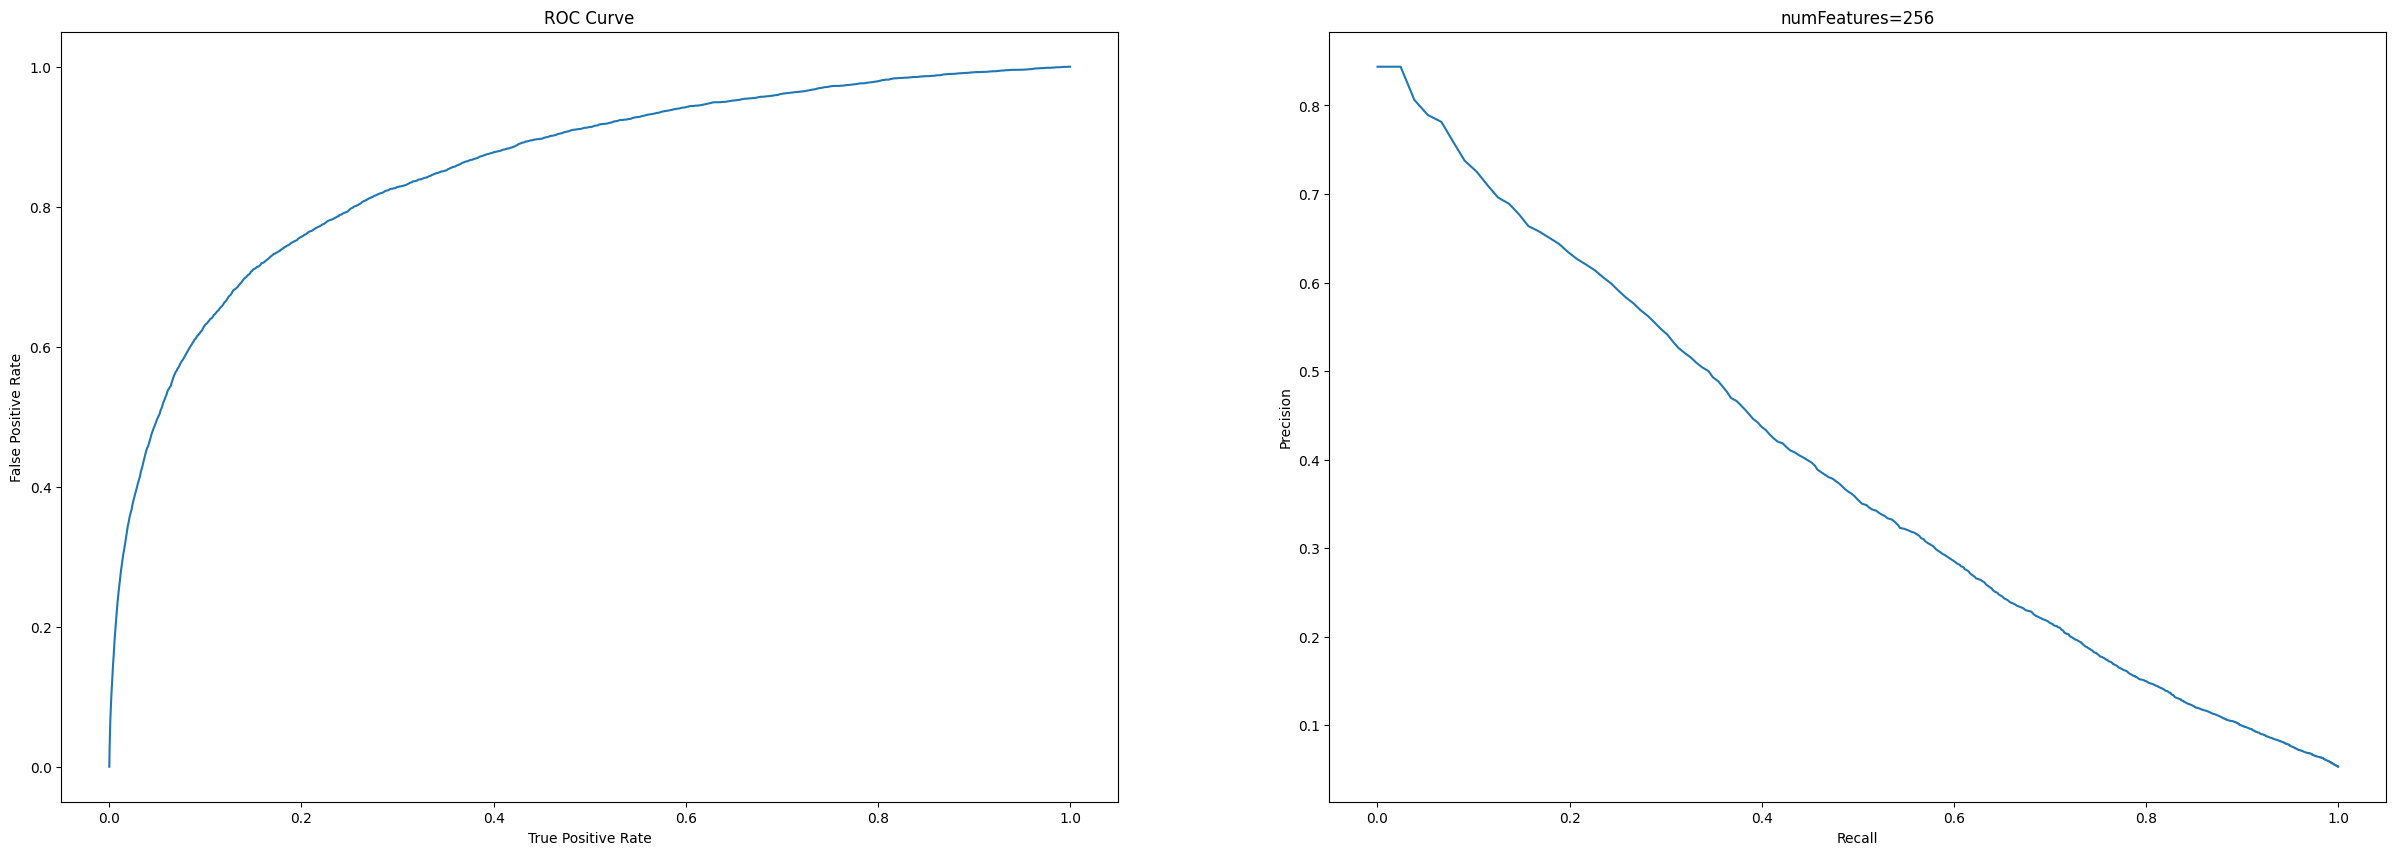

Train areaUnderROC: 0.8543487250703354
Test confusion matrix: obscene


+-------+----------+-----+
|obscene|prediction|count|
+-------+----------+-----+
|      1|       0.0| 1505|
|      0|       0.0|29881|
|      1|       1.0|  182|
|      0|       1.0|   98|
+-------+----------+-----+



In [35]:
label = 'obscene'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

### 4. label: threat

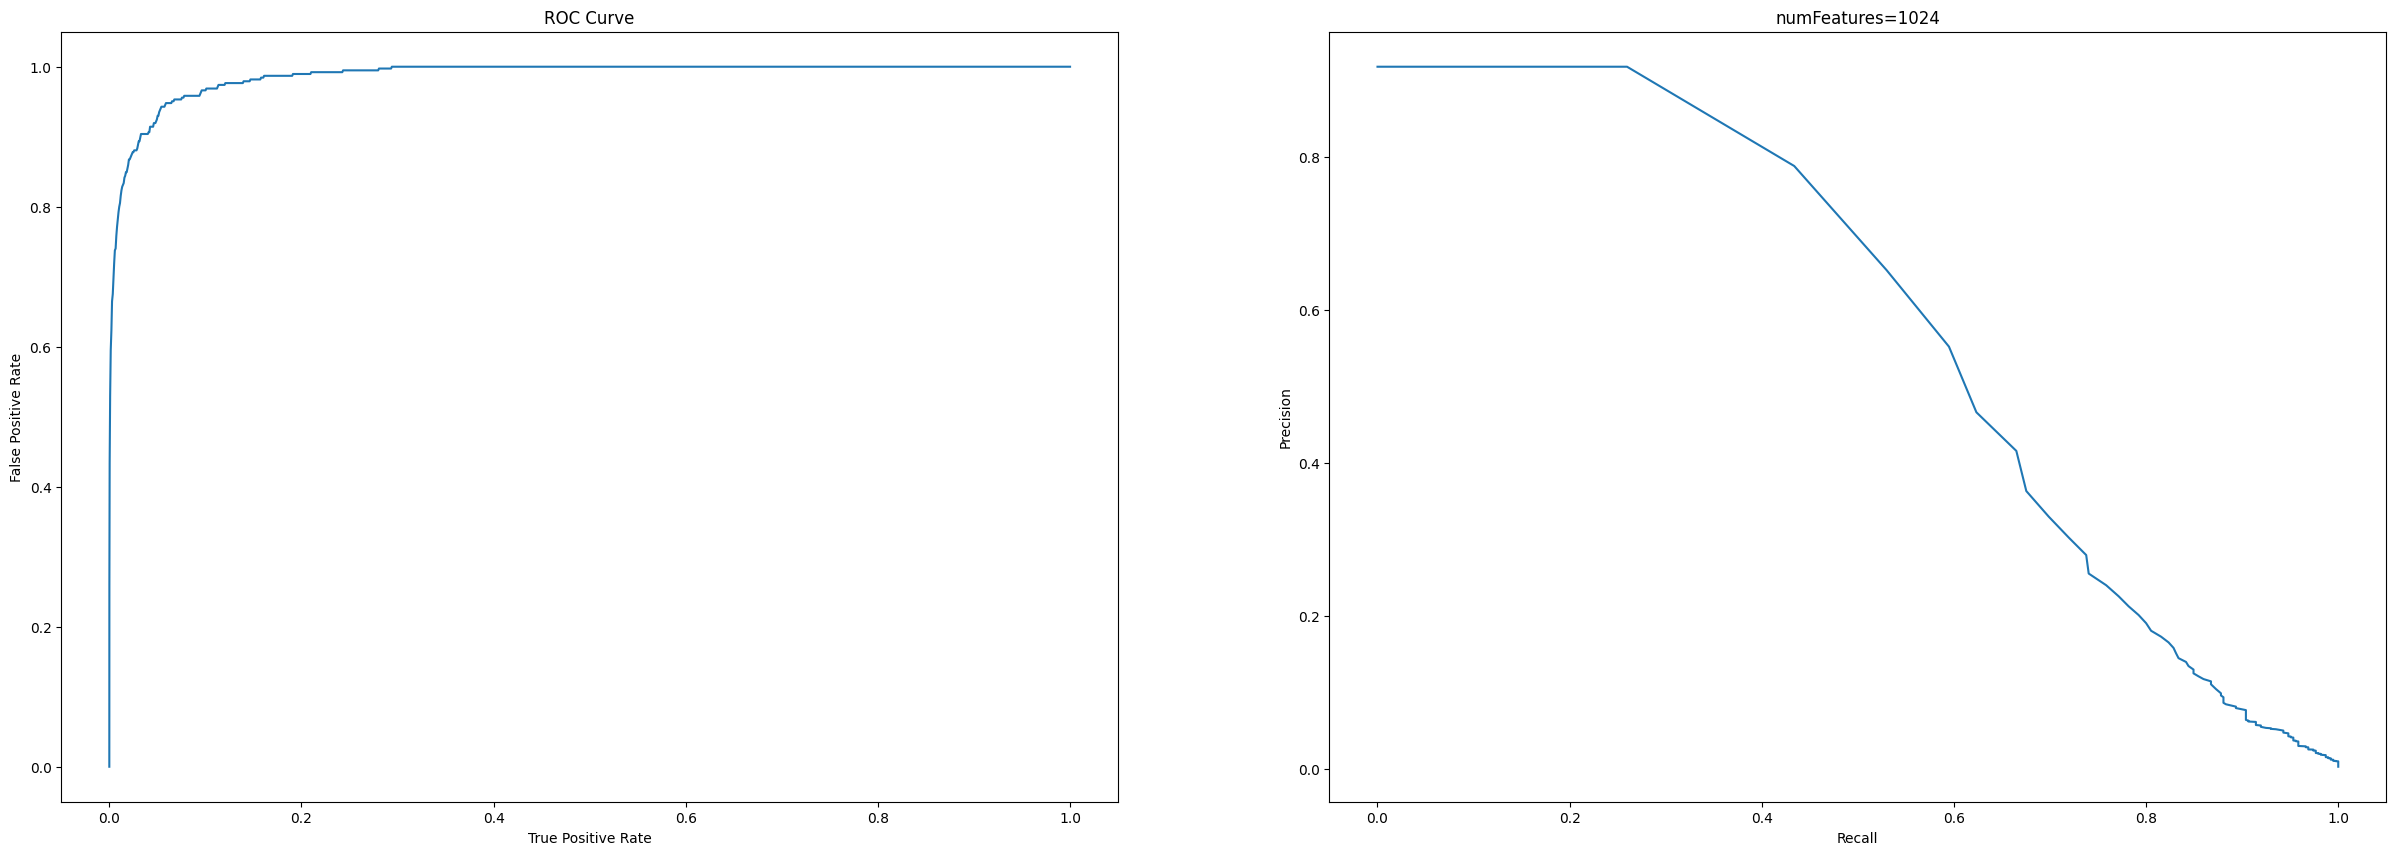

Train areaUnderROC: 0.9872652328704362
Test confusion matrix: threat


+------+----------+-----+
|threat|prediction|count|
+------+----------+-----+
|     1|       0.0|   73|
|     0|       0.0|31552|
|     1|       1.0|   15|
|     0|       1.0|   53|
+------+----------+-----+



In [36]:
label = 'threat'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

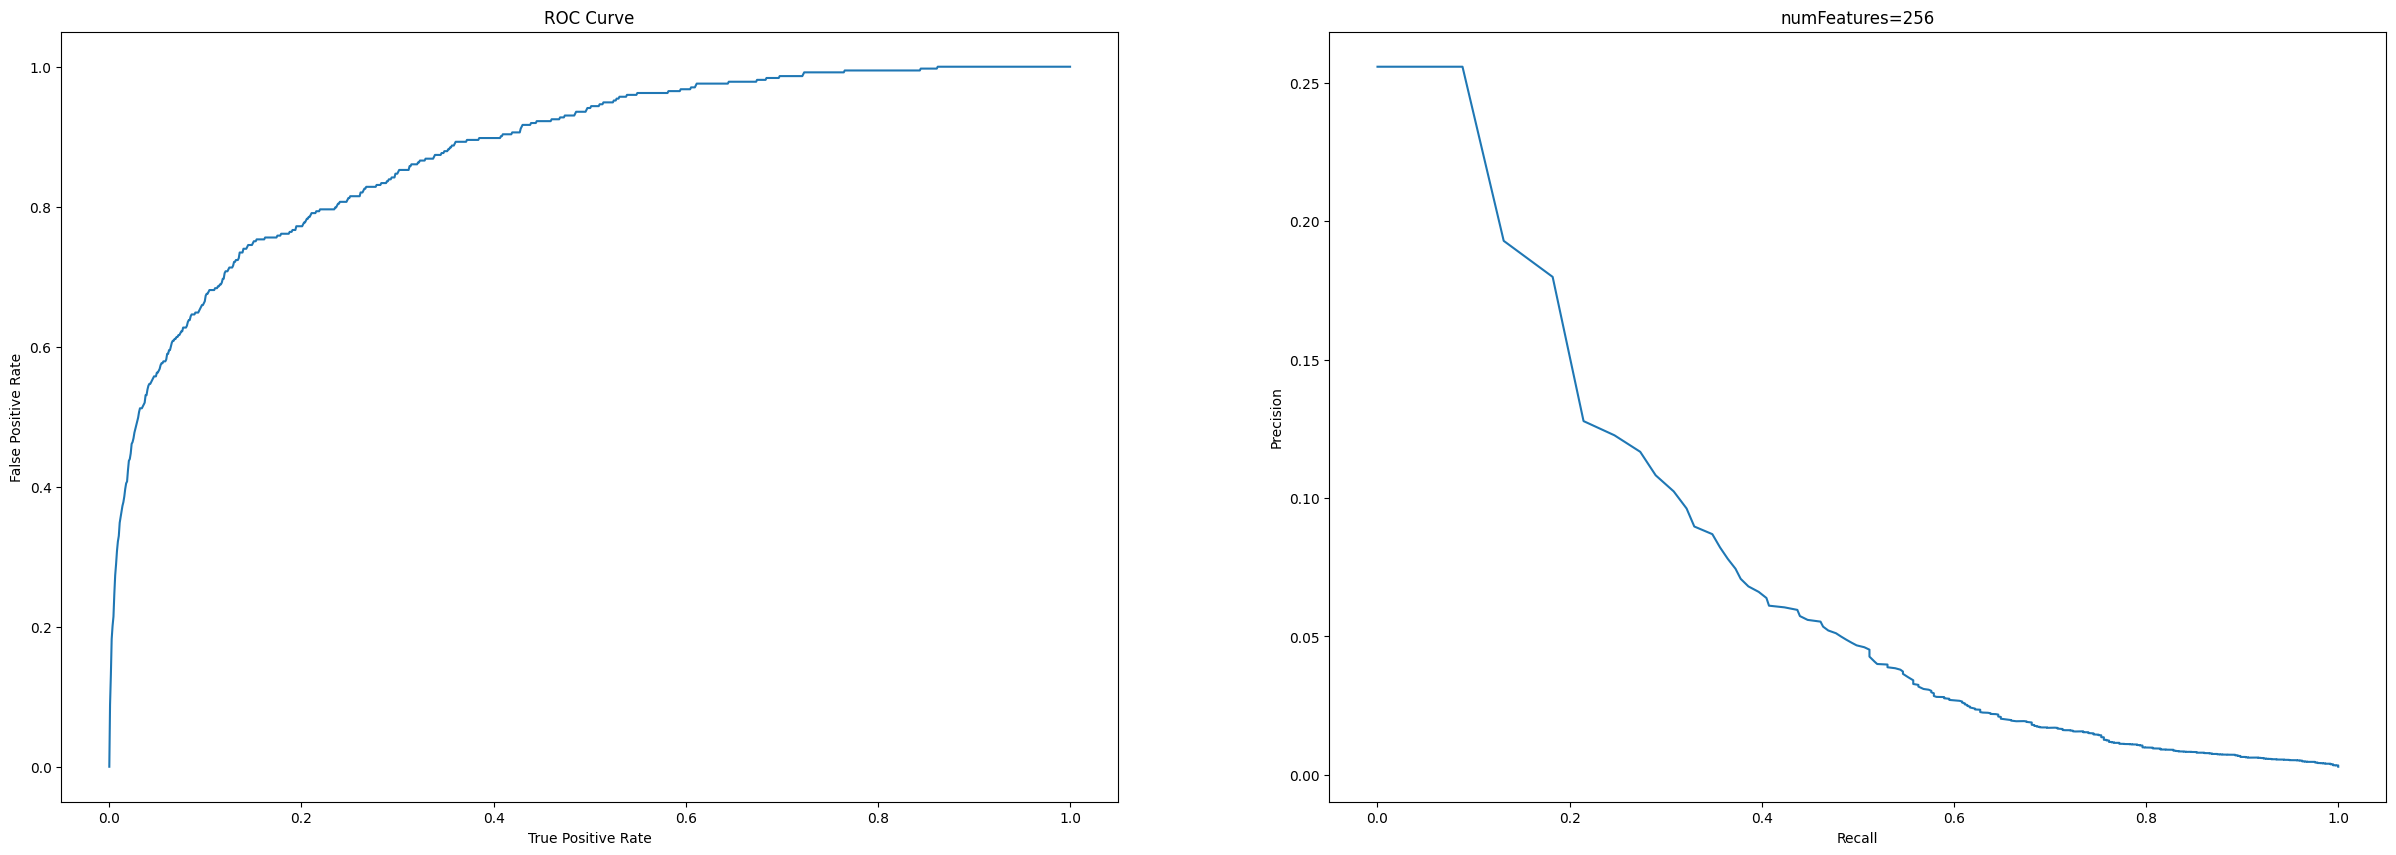

Train areaUnderROC: 0.8794661195888952
Test confusion matrix: threat


+------+----------+-----+
|threat|prediction|count|
+------+----------+-----+
|     1|       0.0|  101|
|     0|       0.0|31558|
|     0|       1.0|    6|
|     1|       1.0|    1|
+------+----------+-----+



In [37]:
label = 'threat'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

### 5. label: insult

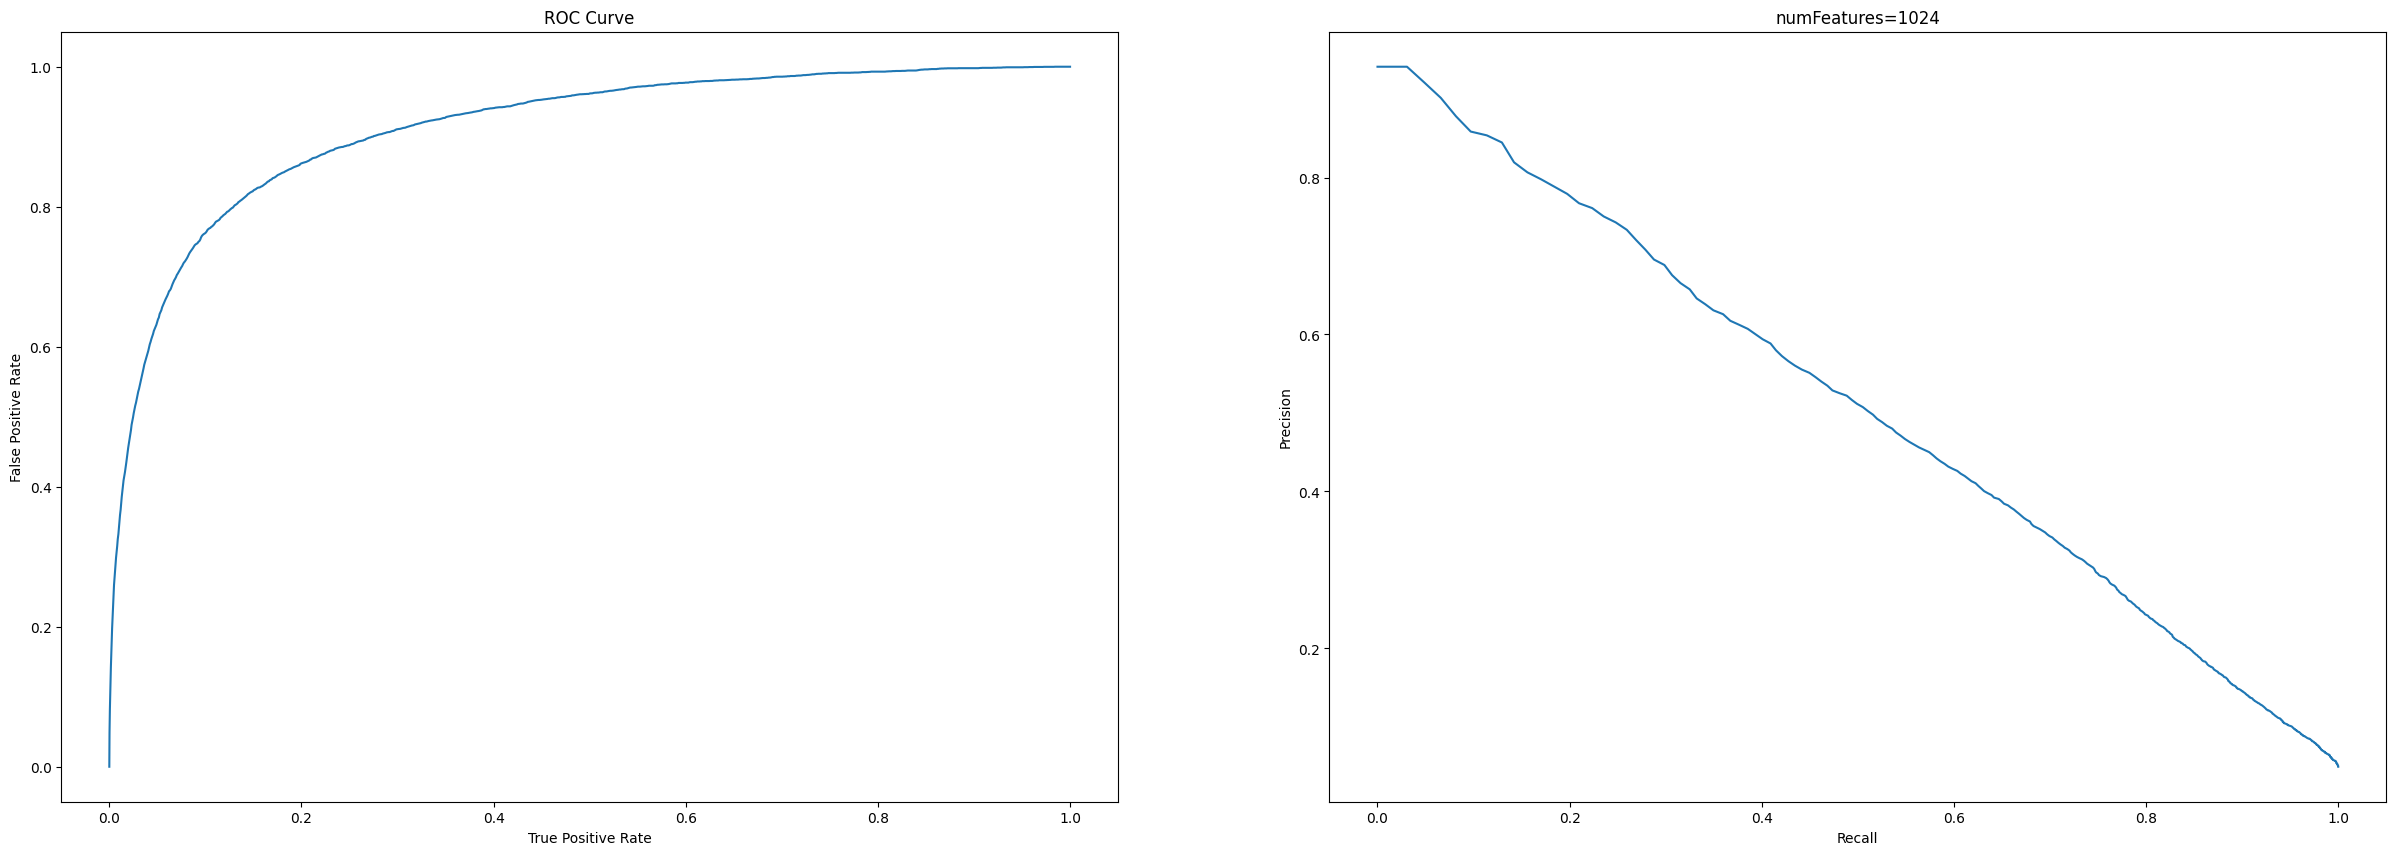

Train areaUnderROC: 0.9109866493293693
Test confusion matrix: insult


+------+----------+-----+
|insult|prediction|count|
+------+----------+-----+
|     1|       0.0| 1240|
|     0|       0.0|29897|
|     1|       1.0|  353|
|     0|       1.0|  203|
+------+----------+-----+



In [38]:
label = 'insult'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

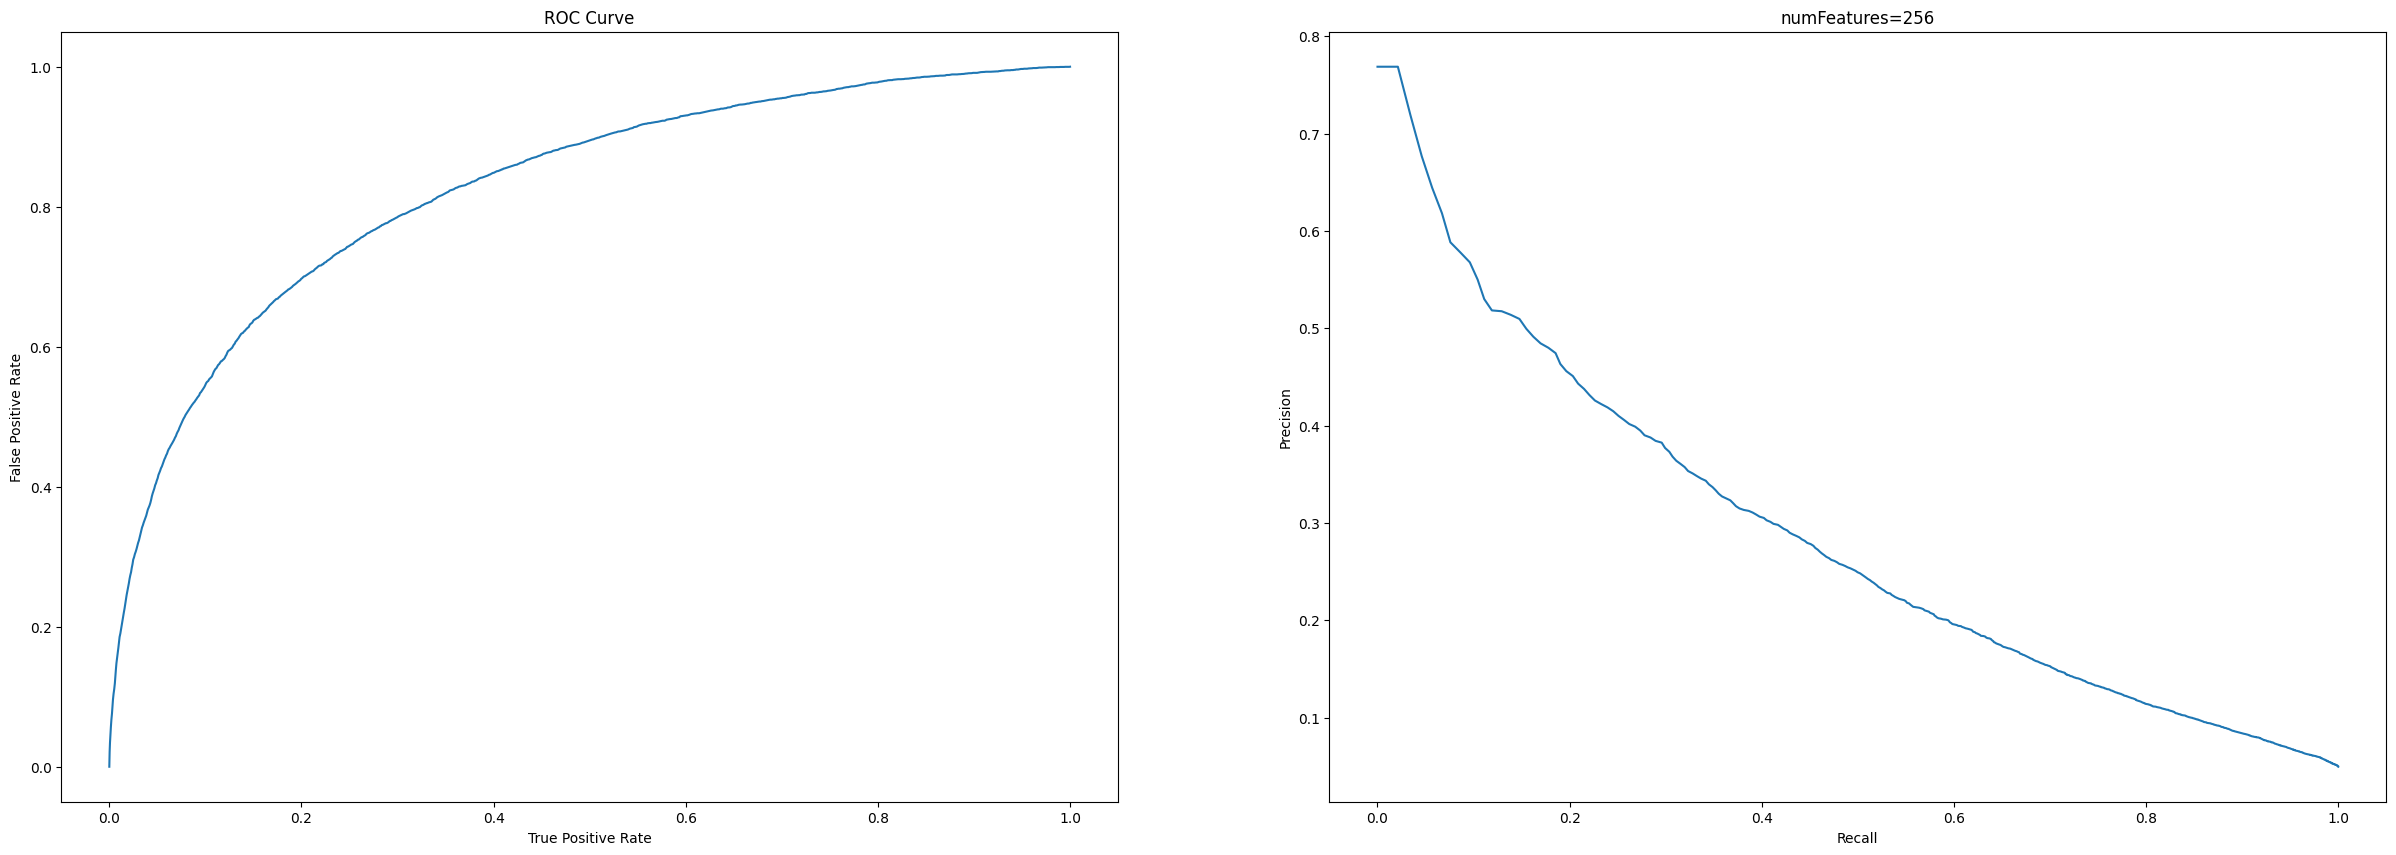

Train areaUnderROC: 0.8248987173791443
Test confusion matrix: insult


+------+----------+-----+
|insult|prediction|count|
+------+----------+-----+
|     1|       0.0| 1525|
|     0|       0.0|30047|
|     1|       1.0|   49|
|     0|       1.0|   45|
+------+----------+-----+



In [39]:
label = 'insult'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

### 6. label: identity_hate

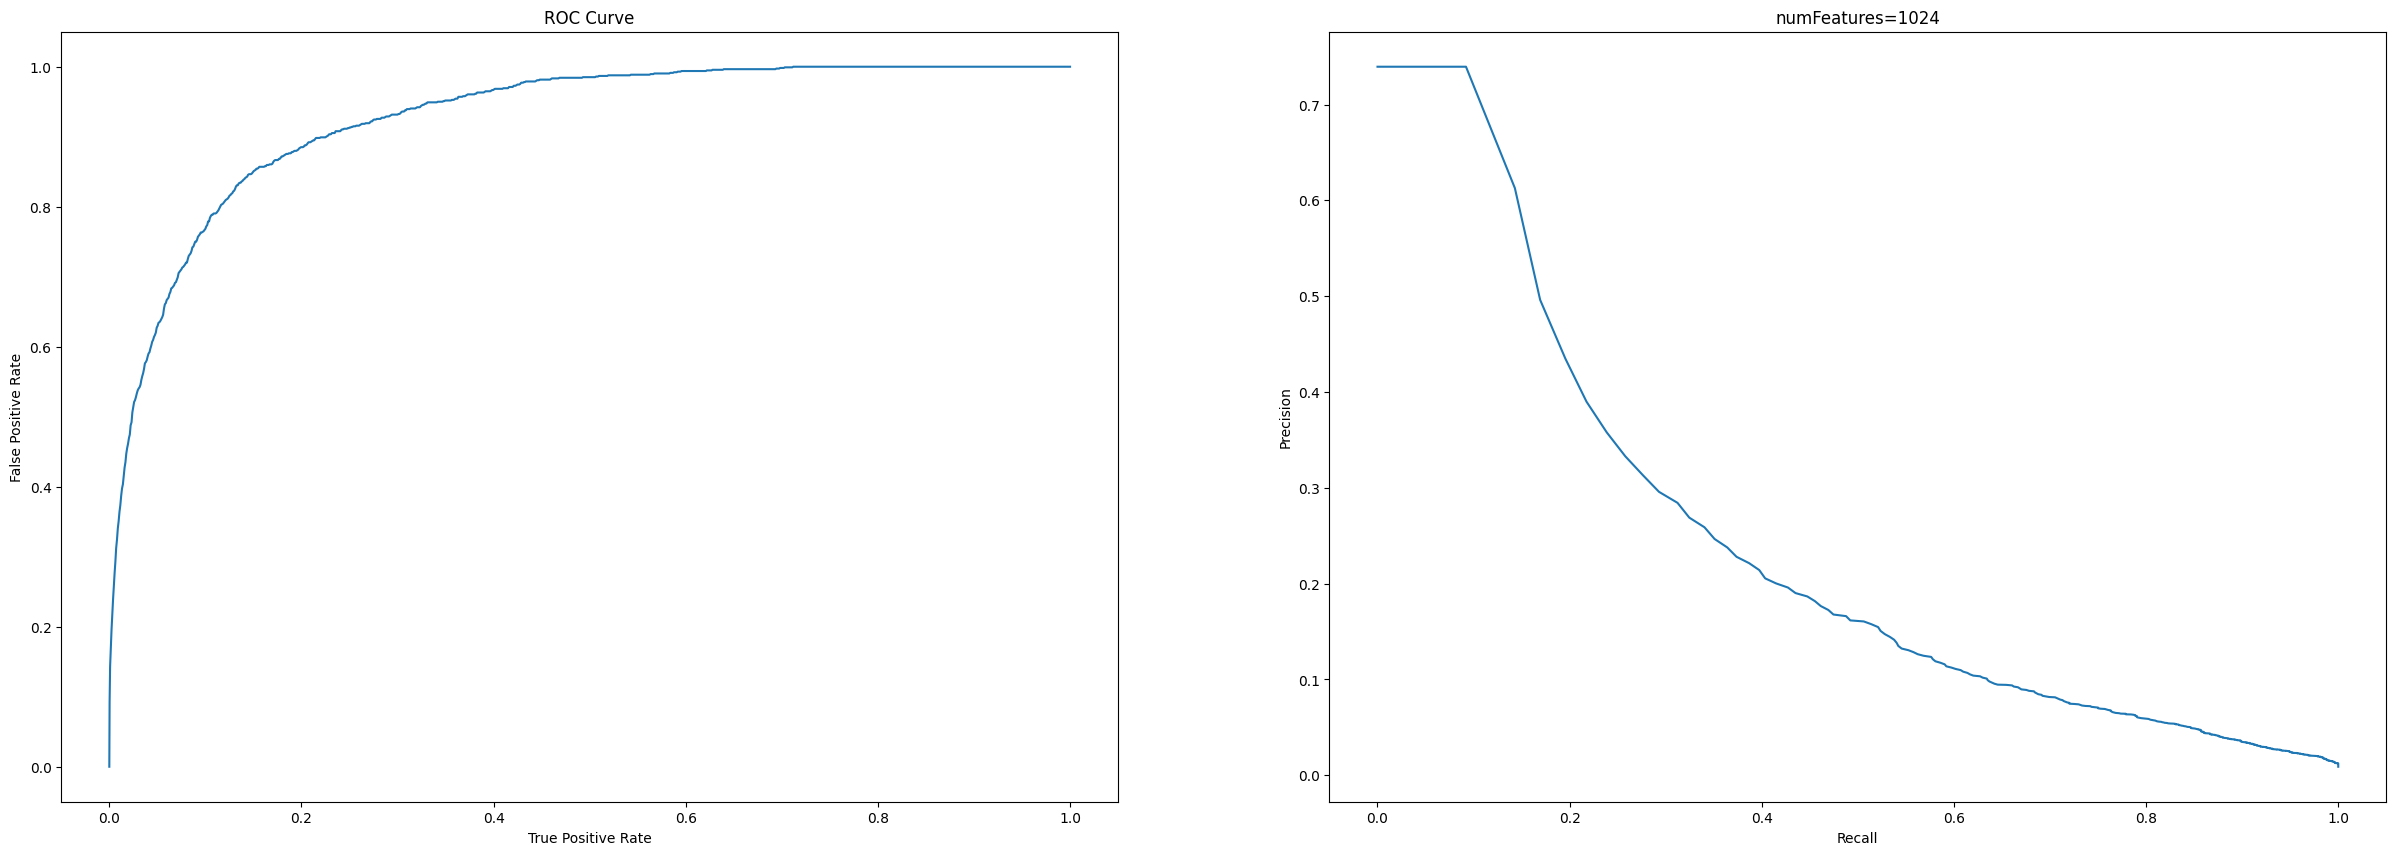

Train areaUnderROC: 0.9255905941781023
Test confusion matrix: identity_hate


+-------------+----------+-----+
|identity_hate|prediction|count|
+-------------+----------+-----+
|            1|       0.0|  246|
|            0|       0.0|31361|
|            1|       1.0|   15|
|            0|       1.0|   71|
+-------------+----------+-----+



In [40]:
label = 'identity_hate'
train = train_1024.select('features', label)
test = test_1024.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=1024')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

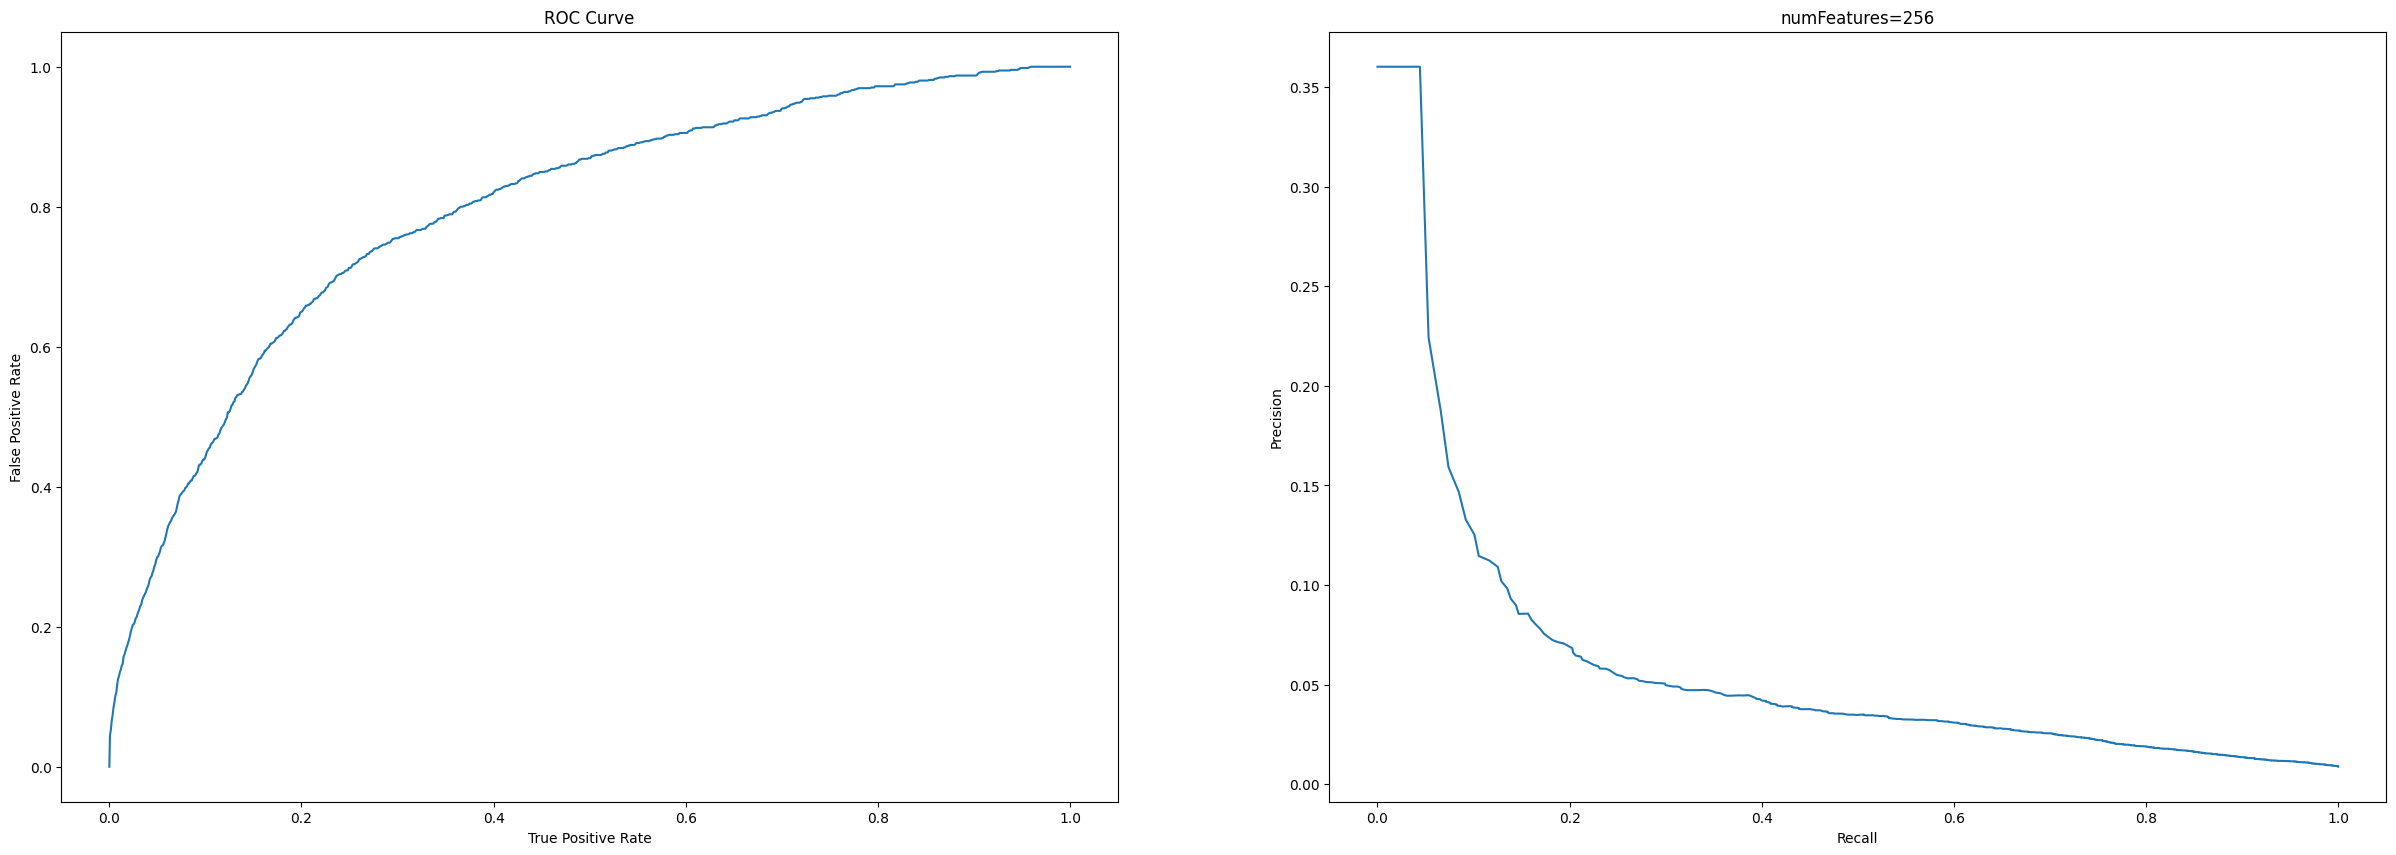

Train areaUnderROC: 0.7935757634052232
Test confusion matrix: identity_hate


+-------------+----------+-----+
|identity_hate|prediction|count|
+-------------+----------+-----+
|            1|       0.0|  289|
|            0|       0.0|31359|
|            1|       1.0|    1|
|            0|       1.0|   17|
+-------------+----------+-----+



In [41]:
label = 'identity_hate'
train = train_256.select('features', label)
test = test_256.select('features', label)

lr = LogisticRegression(featuresCol='features', labelCol=label)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig = plt.figure(figsize=(30, 10))
fig.add_subplot(1,2,1)
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

fig.add_subplot(1,2,2)
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('numFeatures=256')

plt.show()
print('Train areaUnderROC: ' + str(trainingSummary.areaUnderROC))

test_pred = lrModel.transform(test)
print(f'Test confusion matrix: {label}')
test_pred.groupBy(label, 'prediction').count().show()

In [42]:
spark.stop()

### Вывод: по результатам видно,- с уменьшением размера вектора, т.е. количества numFeatures, качество модели падает, и соответственно, метрики снижаются.